# RNN-based clutch control

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
from torch import nn

## Load dataset

In [2]:
dfs = pd.read_excel("../data/Thrust 2 Data Collections/lifting_data_simplified.xlsx",
                    sheet_name=None, # read all sheets (-> dict of DataFrames)
                   )

## Test/train and feature/target selection

In [3]:
TEST_TRIALS = ["trial1"]
TARGET = "rule1"
#FEATURES = slice("pelvis_ax", None)
FEATURES = ['pelvis_ax', 'pelvis_ay', 'pelvis_az',
       't8_ax', 't8_ay', 't8_az', 'pelvis_ex', 'pelvis_ey',
       'pelvis_ez', 't8_ex', 't8_ey', 't8_ez', 'pelvis_q0',
       'pelvis_q1', 'pelvis_q2', 'pelvis_q3', 't8_q0', 't8_q1', 'T8 q2',
       't8_q3']
DELAY = 1

train_seqs = []
test_seqs = []

for trial_name, trial_df in dfs.items():
    features, target = trial_df.loc[:, FEATURES].values, trial_df.loc[:, TARGET].values
    # tape delay
    features, target = features[DELAY:, ...], target[:-DELAY, ...]
    if trial_name in TEST_TRIALS:
        test_seqs.append((features, target))
    else:
        train_seqs.append((features, target))

print(f"Train: {[X.shape for X, _ in train_seqs]}")
print(f"Test: {[X.shape for X, _ in test_seqs]}")

Train: [(84748, 20), (113406, 20), (45963, 20)]
Test: [(79999, 20)]


## Model

In [4]:
HIDDEN_SIZE = 16
NUM_LAYERS = 2

class RNNModel(nn.Module):
    # X: (<1>, seq, features)
    # h0, c0: (num_layers, 1, hidden_size)
    # out: (<1>, seq)
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        #self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.reset_hidden()
        
    def forward(self, x):
        #out, h0 = self.rnn(x, self.h0)  
        # or:
        out, (h0, c0) = self.lstm(x, (self.h0, self.c0))
        out = self.fc(out)
        self.h0, self.c0 = h0.detach(), c0.detach()
        return out
    
    def reset_hidden(self):
        self.h0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        self.c0 = torch.zeros(self.num_layers, 1, self.hidden_size) 

model = RNNModel(train_seqs[0][0].shape[-1], HIDDEN_SIZE, NUM_LAYERS)

## Loss and optimizer

In [5]:
LEARNING_RATE = 0.001

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Train the model

In [6]:
NUM_EPOCHS = 100
BATCH_LEN = 256

model.train()
epoch_steps = sum(X.shape[0] for X, _ in train_seqs) // BATCH_LEN
for epoch in range(NUM_EPOCHS):
    epoch_total_loss = 0
    epoch_total_accuracy = 0
    epoch_samples = 0
    with tqdm(desc=f"Epoch {epoch}", total=epoch_steps) as pbar:
        for seq_X, seq_y in train_seqs:
            #model.reset_hidden()
            for i in range(0, seq_X.shape[0], BATCH_LEN):
                # add dummy batch dimension
                X = torch.from_numpy(seq_X[np.newaxis, i : i + BATCH_LEN]).float()
                # add dummy batch and target dimensions
                y = torch.from_numpy(seq_y[np.newaxis, i : i + BATCH_LEN, np.newaxis] ).float()
                output = model(X)
                loss = criterion(output, y)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_total_loss += loss.item()
                y_hat = torch.where(output.detach() < 0, 0, 1)
                epoch_total_accuracy += torch.sum(y_hat == y).item()
    
                epoch_samples += X.shape[1]
                pbar.update()
                if epoch_samples and epoch_samples % 100 == 0:
                    pbar.set_postfix(loss=epoch_total_loss/epoch_samples,
                                     accuracy=epoch_total_accuracy/epoch_samples)

            
            
        

Epoch 0: 955it [01:01, 15.45it/s, accuracy=0.742, loss=0.00222]                         
Epoch 1: 955it [01:01, 15.54it/s, accuracy=0.783, loss=0.00198]                         
Epoch 2: 955it [01:01, 15.54it/s, accuracy=0.781, loss=0.00196]                         
Epoch 3: 955it [01:01, 15.53it/s, accuracy=0.837, loss=0.00165]                         
Epoch 4: 955it [01:01, 15.52it/s, accuracy=0.869, loss=0.00138]                         
Epoch 5: 955it [01:01, 15.52it/s, accuracy=0.854, loss=0.00138]                         
Epoch 6: 955it [01:01, 15.46it/s, accuracy=0.783, loss=0.00152]                         
Epoch 7: 955it [01:01, 15.41it/s, accuracy=0.839, loss=0.00136]                         
Epoch 8: 955it [01:02, 15.39it/s, accuracy=0.862, loss=0.00121]                         
Epoch 9: 955it [01:01, 15.46it/s, accuracy=0.852, loss=0.00131]                         
Epoch 10: 955it [01:01, 15.46it/s, accuracy=0.841, loss=0.00126]                         
Epoch 11: 955it [01:

## Test the model

In [7]:
model.eval()
pred_seqs = []
total_accuracy = 0
total_samples = 0
with torch.no_grad():
    for seq_X, seq_y in test_seqs:
        model.reset_hidden()
        y_hats = []
        for i in range(0, seq_X.shape[0], BATCH_LEN):
            # add dummy batch dimension
            X = torch.from_numpy(seq_X[np.newaxis, i : i + BATCH_LEN]).float()
            # add dummy batch and target dimensions
            y = torch.from_numpy(seq_y[np.newaxis, i : i + BATCH_LEN, np.newaxis] ).float()
            output = model(X)
            y_hat = torch.where(output < 0, 0, 1)
            y_hats.append(y_hat.view(-1))
            total_accuracy += torch.sum(y_hat == y).item()
            total_samples += y_hat.numel()
            
        pred_seqs.append(torch.cat(y_hats))
        
print(f"Test accuracy: {total_accuracy / total_samples}")

            

Test accuracy: 0.9056863210790135


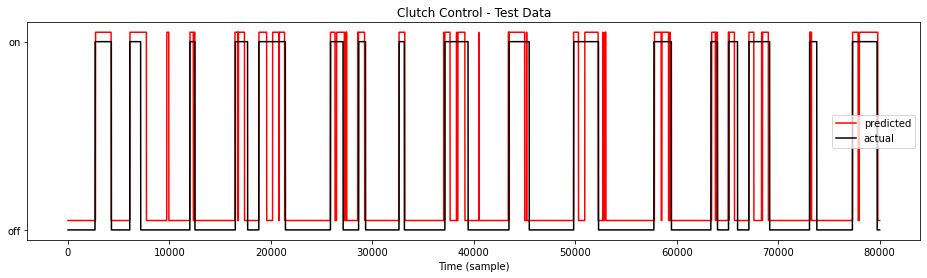

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(pred_seqs[0][:80000] + 0.05, "r", label="predicted");
plt.plot(test_seqs[0][1][:80000], "k", label="actual");
plt.title("Clutch Control - Test Data")
plt.legend()
plt.yticks([0, 1], ["off", "on"])
plt.xlabel("Time (sample)")
plt.savefig("RNN.png")